In [983]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


def f(x):
    return 3 * x**2 - 4 * x + 5

In [984]:
f(3.0)

20.0

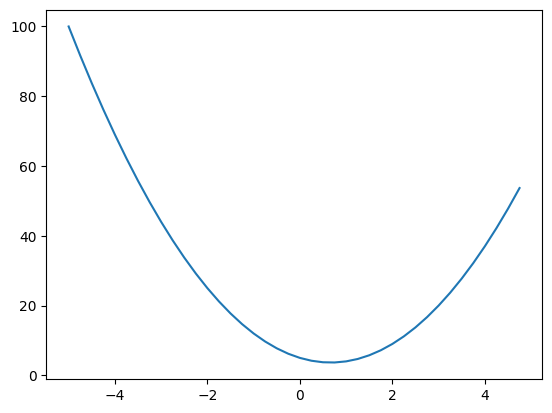

In [985]:
xs = np.arange(-5, 5, 0.25)


ys = f(xs)
plt.plot(xs, ys)

In [986]:
h = 0.0001
x = 3.0
((f(x + h) - f(x)) / h)

14.000300000063248

In [987]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)


4.0


In [988]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print((d2 - d1) / h)


d1 4.0
d2 3.999699999999999
-3.000000000010772


In [989]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

        self._backward = lambda: None

        # initially, doesn't affect the output
        self.grad = 0

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

    def __add__(self, other):
        # wrapping
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad  # chain rule
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + -other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad  # chain rule!
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):  #
        assert isinstance(other, (int, float)), (
            "only supporting int/float powers for now"
        )
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1
    
    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")

e = a * b
e.label = "e"

d = e + c
d.label = "d"
d._op

f = Value(-2.0, label="f")
L = d * f
L

Value(data=-8.0, label=)

In [990]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [991]:
# let's not pollute the global scope
def lol():
    h = 0.0001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    d._op
    f = Value(-2.0, label="f")
    L = d * f
    L1 = L.data

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    d._op

    f = Value(-2.0, label="f")
    L = d * f
    L2 = L.data

    # rise over run
    print((L2 - L1) / h)


lol()

0.0


In [992]:
L.grad = 1
f.grad = 4  # just the value of d
d.grad = -2  # value of f


In [993]:
# Backpropagation

# How do we calculate dL/dc?
# If you know impact of c on d, then you know how c impacts L

# recall: d = e + c
# dd / dc - 1.0
# dd / de - 1.0

# dL/dc = dL/dd * dd/dc
c.grad = -2.0
e.grad = -2.0

# e = a * b
# dL / de = -2.0
# dL / da = dL / de * de/da
# de / da = b
a.grad = (-2.0) * -3.0
b.grad = (-2.0) * 2.0

In [994]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

# we nudged all the positive gradients
# we expect L to be less negative
print(L.data)

-7.286496


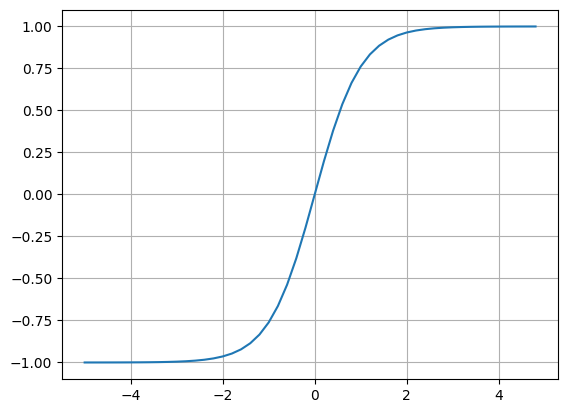

In [995]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [996]:
# inputs x1, x2

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

# intermediates
x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b
n.label = "n"

# change how we define o
e = (2 * n).exp()
o = (e - 1) / (e + 1)

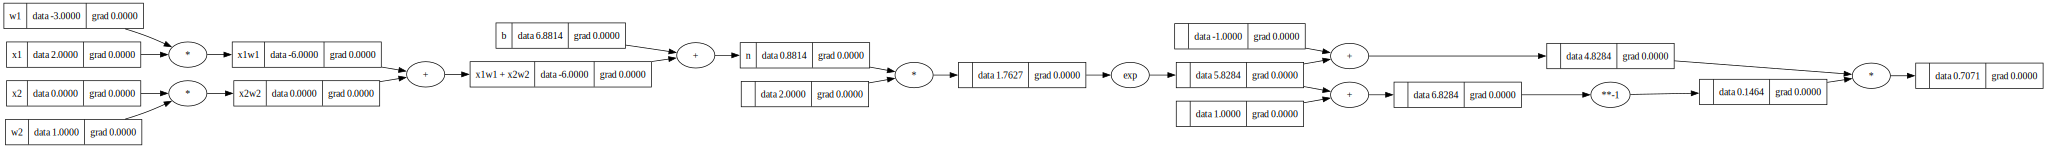

In [997]:
draw_dot(o)

In [998]:
o.grad = 1.0  # base case

# just get the derivative of tanh from somewhere
# do/dn = 1-(tanh(n))**2
# do/dn = 1 - o**2
# n.grad = 0.5

In [999]:
# dL/x1w1x2w2 = dL/dn (.5) * dn/x1... (1)
# x1w1x2w2.grad = 0.5
# b.grad = 0.5

In [1000]:
# x1w1.grad = 0.5
# x2w2.grad = 0.5

# # x2.grad = 0.5 * w2
# x2.grad = x2w2.grad * w2.data
# w2.grad = x2w2.grad * x2.data
# x1.grad = x1w1.grad * w1.data
# w1.grad = x1w1.grad * x1.data

In [1001]:
# o.grad = 1.0
# o._backward()  # propagates to tanh
# n._backward()
# b._backward()  # leaf node
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

In [1002]:
# topological sort
# reverse post order

topo = []
visited = set()


def build_topo(v):
    if f not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)


build_topo(o)

# for node in reversed(topo):
#     node._backward()
o.backward()

In [1003]:
# Bug
# a = Value(3.0, label='a')
# b = a + a
# b.label = 'b'

# b.backward()
# draw_dot(b)


In [1004]:
# a = Value(2.0)
# b = Value(4.0)
# a / b

In [1005]:
# same thing in pytorch

import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print(x1.grad.item(), w1.grad.item())
print(x2.grad.item(), w2.grad.item())

0.7071066904050358
-1.5000003851533106 1.0000002567688737
0.5000001283844369 0.0


In [1006]:
import random


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [1007]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

In [1008]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]


In [1046]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 0.0005400733769014741
1 0.0005392499990249143
2 0.0005384290850916648
3 0.0005376106241325503
4 0.000536794605243149
5 0.0005359810175833661
6 0.0005351698503769014
7 0.0005343610929108454
8 0.000533554734535149
9 0.0005327507646622362
10 0.0005319491727664685
11 0.000531149948383774
12 0.0005303530811111304
13 0.0005295585606061624
14 0.0005287663765866774
15 0.0005279765188302615
16 0.000527188977173831
17 0.0005264037415131674
18 0.0005256208018025473
19 0.0005248401480542919


In [1010]:
# loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
# loss

In [1011]:
# loss.backward()
# n.layers[0].neurons[0].w[0].data

In [1012]:
# n.layers[0].neurons[0].w[0].grad

In [1013]:
# for p in n.parameters():
#     p.data += -0.01 * p.grad
# n.layers[0].neurons[0].w[0].data